In [23]:
import json

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

from datasets import get_CIFAR10, get_SVHN
from model_eval_nodropout import Glow

torch.cuda.set_device(0)
device = torch.device("cuda:0")

output_folder = 'output/'
model_name = 'glow_model_37.pth'

# output_folder = 'output/cifar_nolabel/'
# model_name = 'glow_model_250.pth'

with open(output_folder + 'hparams.json') as json_file:  
    hparams = json.load(json_file)
    
print(hparams)

image_shape, num_classes, train_cifar, test_cifar = get_CIFAR10(hparams['augment'], hparams['dataroot'], hparams['download'])
image_shape, num_classes, train_svhn, test_svhn = get_SVHN(hparams['augment'], hparams['dataroot'], hparams['download'])

model = Glow(image_shape, hparams['hidden_channels'], hparams['K'], hparams['L'], hparams['actnorm_scale'],
             hparams['flow_permutation'], hparams['flow_coupling'], hparams['LU_decomposed'], num_classes,
             hparams['learn_top'], hparams['y_condition'])

model.load_state_dict(torch.load(output_folder + model_name))
model.set_actnorm_init()

model = model.to(device)
model = model.eval()

{'K': 32, 'L': 3, 'LU_decomposed': True, 'actnorm_scale': 1.0, 'augment': True, 'batch_size': 64, 'cuda': True, 'dataroot': './', 'dataset': 'cifar10', 'download': True, 'epochs': 1000, 'eval_batch_size': 512, 'flow_coupling': 'affine', 'flow_permutation': 'invconv', 'fresh': False, 'gpuid': 0, 'hidden_channels': 512, 'learn_top': True, 'lr': 0.0005, 'max_grad_clip': 0, 'max_grad_norm': 0, 'n_init_batches': 8, 'n_workers': 6, 'output_dir': 'output/cifar_linear_weighted', 'saved_model': '', 'saved_optimizer': '', 'seed': 0, 'warmup': 5, 'warmup_steps': 4000, 'y_condition': True, 'y_weight': 1.0}
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: data/SVHN/train_32x32.mat
Using downloaded and verified file: data/SVHN/test_32x32.mat


In [13]:
def compute_nll(dataset, model):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, num_workers=6)
    
    nlls = []
    for x,y in dataloader:
        x = x.to(device)
        
        if hparams['y_condition']:
            y = y.to(device)
        else:
            y = None
        
        with torch.no_grad():
            _, nll, _, _ = model(x, y_onehot=y)
            nlls.append(nll)
        
    return torch.cat(nlls).cpu()

In [9]:
def compute_logpz(dataset, model):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, num_workers=6)
    
    logpzs = []
    for x,y in dataloader:
        x = x.to(device)
        
        if hparams['y_condition']:
            y = y.to(device)
        else:
            y = None
        
        with torch.no_grad():
            _, _, _, logpz = model(x, y_onehot=y)
            logpzs.append(logpz)
        
    return torch.cat(logpzs).cpu()

In [4]:
def compute_acc(dataset, model):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, num_workers=6)
    
    correct = 0
    num_samples = 0
    for x,y in dataloader:
        x = x.to(device)
        
        if hparams['y_condition']:
            y = y.to(device)
        else:
            y = None
        
        with torch.no_grad():
            _, _, y_logits, _ = model(x, y_onehot=y)
            predicted_label = torch.argmax(y_logits, dim=1).cpu()
            true_label = torch.argmax(y, dim=1).cpu()
            inds, = np.where(predicted_label == true_label)
            correct += len(inds)
            num_samples += y.shape[0]
        
    return correct / num_samples

In [27]:
# with model eval
# epoch 8: 0.32892(train)
# epoch 18: 0.4196(train), 0.4239
# epoch 37: 0.4855
accuracy = compute_acc(test_cifar, model)
print(accuracy)

0.48104


In [21]:
cifar_nll = compute_nll(test_cifar, model)
svhn_nll = compute_nll(test_svhn, model)
cifar_nll_train = compute_nll(train_cifar, model)

print("CIFAR NLL", torch.mean(cifar_nll))
print("SVHN NLL", torch.mean(svhn_nll))

CIFAR NLL tensor(4.9087)
SVHN NLL tensor(3.6191)


In [25]:
# with label epoch 37
cifar_pz = compute_logpz(test_cifar, model)
svhn_pz = compute_logpz(test_svhn, model)
cifar_train_pz = compute_logpz(train_cifar, model)

print("CIFAR log p(z)", torch.mean(cifar_pz))
print("SVHN log p(z)", torch.mean(svhn_pz))

CIFAR log p(z) tensor(-1420.6329)
SVHN log p(z) tensor(-1283.9110)


In [11]:
# without label: pretrained
cifar_pz = compute_logpz(test_cifar, model)
svhn_pz = compute_logpz(test_svhn, model)

print("CIFAR log p(z)", torch.mean(cifar_pz))
print("SVHN log p(z)", torch.mean(svhn_pz))

CIFAR log p(z) tensor(-87200.7969)
SVHN log p(z) tensor(-222966.2031)


In [19]:
# without label: self trained
cifar_pz = compute_logpz(test_cifar, model)
svhn_pz = compute_logpz(test_svhn, model)
cifar_train_pz = compute_logpz(train_cifar, model)

print("CIFAR log p(z)", torch.mean(cifar_pz))
print("SVHN log p(z)", torch.mean(svhn_pz))

CIFAR log p(z) tensor(-1083.5750)
SVHN log p(z) tensor(-1105.4014)


## p(x) with label

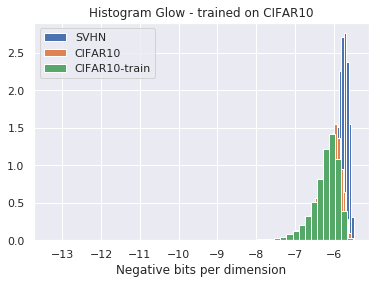

In [17]:
plt.figure()
plt.title("Histogram Glow - trained on CIFAR10")
plt.xlabel("Negative bits per dimension")
plt.hist(-svhn_nll.numpy(), label="SVHN", density=True, bins=30)
plt.hist(-cifar_nll.numpy(), label="CIFAR10", density=True, bins=50)
plt.hist(-cifar_nll_train.numpy(), label="CIFAR10-train", density=True, bins=50)
plt.legend()
plt.show()

## log p(z|y) with label

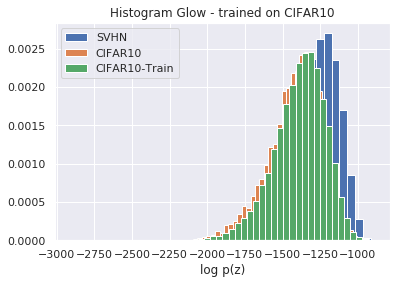

In [26]:
plt.figure()
plt.title("Histogram Glow - trained on CIFAR10")
plt.xlabel("log p(z)")
plt.hist(svhn_pz.numpy(), label="SVHN", density=True, bins=30)
plt.hist(cifar_pz.numpy(), label="CIFAR10", density=True, bins=50)
plt.hist(cifar_train_pz.numpy(), label="CIFAR10-Train", density=True, bins=50)
plt.legend()
plt.show()

## log p(x) without label

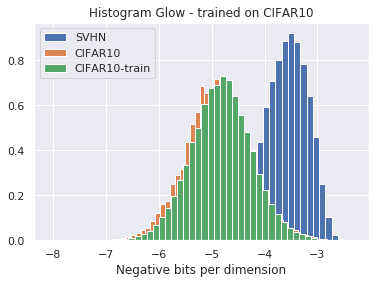

In [22]:
plt.figure()
plt.title("Histogram Glow - trained on CIFAR10")
plt.xlabel("Negative bits per dimension")
plt.hist(-svhn_nll.numpy(), label="SVHN", density=True, bins=30)
plt.hist(-cifar_nll.numpy(), label="CIFAR10", density=True, bins=50)
plt.hist(-cifar_nll_train.numpy(), label="CIFAR10-train", density=True, bins=50)
plt.legend()
plt.show()

## log p(z) without label

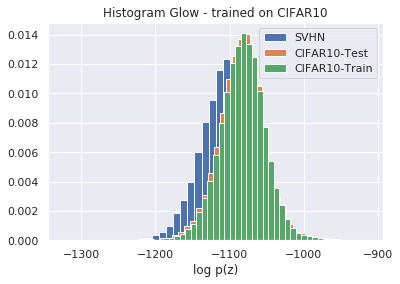

In [20]:
# no label: self_trained
plt.figure()
plt.title("Histogram Glow - trained on CIFAR10")
plt.xlabel("log p(z)")
plt.hist(svhn_pz.numpy(), label="SVHN", density=True, bins=30)
plt.hist(cifar_pz.numpy(), label="CIFAR10-Test", density=True, bins=50)
plt.hist(cifar_train_pz.numpy(), label="CIFAR10-Train", density=True, bins=50)
plt.legend()
plt.show()

## SVHN

In [38]:
# with label: self trained
cifar_pz = compute_logpz(test_cifar, model)
svhn_pz = compute_logpz(test_svhn, model)
svhn_train_pz = compute_logpz(train_svhn, model)

print("CIFAR log p(z)", torch.mean(cifar_pz))
print("SVHN log p(z)", torch.mean(svhn_pz))

CIFAR log p(z) tensor(-1154.6949)
SVHN log p(z) tensor(-1082.6204)


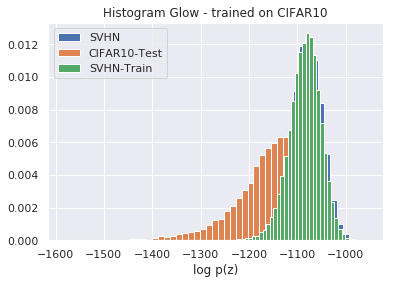

In [39]:
# with label: self_trained
plt.figure()
plt.title("Histogram Glow - trained on CIFAR10")
plt.xlabel("log p(z)")
plt.hist(svhn_pz.numpy(), label="SVHN", density=True, bins=30)
plt.hist(cifar_pz.numpy(), label="CIFAR10-Test", density=True, bins=50)
plt.hist(svhn_train_pz.numpy(), label="SVHN-Train", density=True, bins=50)
plt.legend()
plt.show()

In [43]:
# without label: self trained
cifar_pz = compute_logpz(test_cifar, model)
svhn_pz = compute_logpz(test_svhn, model)
svhn_train_pz = compute_logpz(train_svhn, model)

print("CIFAR log p(z)", torch.mean(cifar_pz))
print("SVHN log p(z)", torch.mean(svhn_pz))

CIFAR log p(z) tensor(-1187.5631)
SVHN log p(z) tensor(-1088.8761)


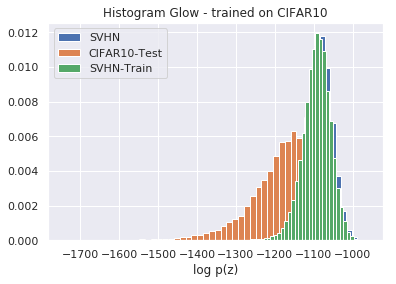

In [44]:
# with label: self_trained
plt.figure()
plt.title("Histogram Glow - trained on CIFAR10")
plt.xlabel("log p(z)")
plt.hist(svhn_pz.numpy(), label="SVHN", density=True, bins=30)
plt.hist(cifar_pz.numpy(), label="CIFAR10-Test", density=True, bins=50)
plt.hist(svhn_train_pz.numpy(), label="SVHN-Train", density=True, bins=50)
plt.legend()
plt.show()

In [40]:
cifar_pz = torch.randn([50,50])
cifar_pz.shape

torch.Size([50, 50])

In [41]:
test = torch.zeros(cifar_pz.shape)
print(test.shape)

torch.Size([50, 50])
